In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import sys
THRID_PARTY_LIB_PATH = (
    "../../../../SPEER/", # esg_tools
)
for path in THRID_PARTY_LIB_PATH:
    path = os.path.abspath(path)
    if path not in sys.path:
        sys.path.append(path)

from esg_tools import get_all_entity_strs, get_all_entity_strs, entity_coverage_check, metric_Entity_Recall

/data/huengchi/.bin/anaconda3/envs/torch-2.1-py-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_SET='../../datasets/mimic-iii-notes/NOTES_len6K_src5900_cov0.5_w_ESGs_test_split.jsonl'
MODEL_OUTPUT='../../outputs/MedSum_20240320153833_hexyne-nonworking-82'

In [3]:
PREDICTION_SET=os.path.join(MODEL_OUTPUT, 'evals', 'predictions.jsonl')
METRIC_SET=os.path.join(MODEL_OUTPUT, 'evals', 'metric_scores.jsonl')
OUTPUT_DIR=os.path.join(MODEL_OUTPUT, 'evals', 'analysis')
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
test_set = pd.read_json(TEST_SET, lines=True)
pred_set = pd.read_json(PREDICTION_SET, lines=True)
metric_set = pd.read_json(METRIC_SET, lines=True)

test_set = test_set.rename(columns={'example_id': 'id'})

for df in (test_set, pred_set, metric_set):
    print(df.columns)

Index(['id', 'source', 'target', 'len_source', 'len_target', 'len_total',
       'label_entity_coverage_rate', 'source_orig', 'len_src_tok',
       'len_tgt_tok', 'len_total_tok', 'oracle_salient_ESGs'],
      dtype='object')
Index(['id', 'output'], dtype='object')
Index(['id', 'SGR', 'HR', 'rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4',
       'bs_f1', 'bs_p'],
      dtype='object')


In [5]:
def three_table_inner_join(df1, df2, df3, join_key):
    return pd.merge(
                pd.merge(
                    df1,
                    df2, on=join_key, how='inner'),
                df3, on=join_key, how='inner')

In [6]:
result_set = three_table_inner_join(test_set, pred_set, metric_set, join_key='id')

In [7]:
assert test_set.shape[0] == pred_set.shape[0] == metric_set.shape[0] == result_set.shape[0]

In [16]:
# Entity Recall Computation

def compute_ER(row):
    src_txt = row['source']
    tgt_txt = row['target']
    gen_txt = row['output']
    row['ER_src_tgt'] = metric_Entity_Recall(ref_txt=src_txt, input_txt=tgt_txt)
    row['ER_tgt_gen'] = metric_Entity_Recall(ref_txt=tgt_txt, input_txt=gen_txt)
    row['ER_src_gen'] = metric_Entity_Recall(ref_txt=src_txt, input_txt=gen_txt)
    
    row['ER_tgt_src'] = metric_Entity_Recall(ref_txt=tgt_txt, input_txt=src_txt)
    row['ER_gen_src'] = metric_Entity_Recall(ref_txt=gen_txt, input_txt=src_txt)
    return row

In [15]:
tqdm.pandas()
result_set = result_set.progress_apply(compute_ER, axis=1)

100%|██████████| 266/266 [00:46<00:00,  5.75it/s]


In [17]:
result_set.columns

Index(['id', 'source', 'target', 'len_source', 'len_target', 'len_total',
       'label_entity_coverage_rate', 'source_orig', 'len_src_tok',
       'len_tgt_tok', 'len_total_tok', 'oracle_salient_ESGs', 'output', 'SGR',
       'HR', 'rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4', 'bs_f1', 'bs_p',
       'ER_src_tgt', 'ER_tgt_gen', 'ER_src_gen', 'ER_tgt_src', 'ER_gen_src'],
      dtype='object')

In [18]:
metric_keys = ['SGR', 'HR', 'rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4', 'bs_f1', 'bs_p',
                'ER_src_tgt', 'ER_tgt_gen', 'ER_src_gen', 'ER_tgt_src', 'ER_gen_src']
# metric_keys = ['rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4', 'bs_f1', 'bs_p']
for k in metric_keys:
    print(k, np.mean(result_set[k]))

SGR 0.6423350076552633
HR 0.8481325374736842
rouge-1% 22.203797368421053
rouge-2% 6.649811278195489
rouge-l% 14.080552255639097
bleu-4 16.60246842105263
bs_f1 0.33148940765751883
bs_p 0.383118381793609
ER_src_tgt 0.2311609174533403
ER_tgt_gen 0.17107577653365866
ER_src_gen 0.10404559920085305
ER_tgt_src 0.5990715683674036
ER_gen_src 0.6126825125898006


In [64]:
df_to_plot = result_set.copy()
# plot_columns = ['ER_src_tgt', 'ER_tgt_gen', 'ER_src_gen', 'ER_tgt_src', 'ER_gen_src']
plot_columns = ['ER_tgt_src', 'ER_gen_src']
plot_columns = ['ER_tgt_src']
smoothed_plot_columns = []
for col in plot_columns:
    df_to_plot[f"smooth_{col}"] = df_to_plot[col].ewm(alpha=0.01, adjust=True).mean()
    smoothed_plot_columns.append(f"smooth_{col}")

<Axes: >

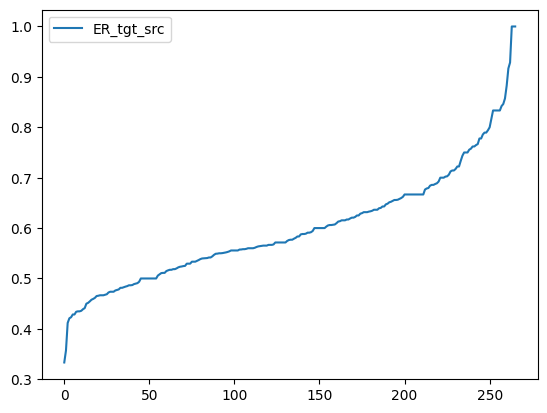

In [65]:
df_to_plot.sort_values(by='ER_tgt_src').reset_index(drop=True).plot(y=plot_columns,
                kind='line')
# df_to_plot.sort_values(by='ER_tgt_gen').reset_index(drop=True).plot(y=smoothed_plot_columns,
#                 kind='line')

In [40]:
df_to_plot.sort_values(by='ER_tgt_gen').reset_index(drop=True).iloc[-1]

id                                                                  63878101540
source                        , J. NSURG CC1A 2:44 PM {{CT HEAD W O CONTRAST...
target                        50F s p angiogram and coiling, post-angio she ...
len_source                                                                 4970
len_target                                                                  178
len_total                                                                  5148
label_entity_coverage_rate                                                  1.0
source_orig                   , J. NSURG CC1A 2:44 PM CT HEAD W O CONTRAST C...
len_src_tok                                                                1637
len_tgt_tok                                                                  57
len_total_tok                                                              1694
oracle_salient_ESGs           [[EMBO TRANSCRANIAL SEL CATH 2ND ORDER, Stent ...
output                        The patien

In [28]:
# Entity coverage rate in gen text

def compute_entity_coverage(row):
    src_entities = get_all_entity_strs(row['source'])
    tgt_entities = get_all_entity_strs(row['output'])
    coverage_rate = 0
    if len(src_entities)>0 and len(tgt_entities)>0:
        coverage_label = entity_coverage_check(entities_to_check=tgt_entities,
                                    grounding_entities=src_entities,
                                    similarity_thres=0.6)
        coverage_rate = np.mean(coverage_label)
    row['gen_entity_coverage_rate'] = coverage_rate
    return row

In [29]:
tqdm.pandas()
result_set=result_set.progress_apply(compute_entity_coverage, axis=1)

2024-03-20 12:01:11 INFO: Downloaded file to //data/huengchi/stanza_resources/resources.json
2024-03-20 12:01:11 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| pretrain        | mimic          |
| backward_charlm | mimic          |
| forward_charlm  | mimic          |

2024-03-20 12:01:11 INFO: File exists: //data/huengchi/stanza_resources/en/tokenize/mimic.pt
2024-03-20 12:01:11 INFO: File exists: //data/huengchi/stanza_resources/en/pos/mimic_charlm.pt
2024-03-20 12:01:11 INFO: File exists: //data/huengchi/stanza_resources/en/lemma/mimic_nocharlm.pt
2024-03-20 12:01:12 INFO: File exists: //data/huengchi/stanza_resources/en/depparse/mimic_charlm.pt
2024-03-20 12:01:12 INFO: File exists: //data/huengchi/

In [ ]:
# Saving

result_set.to_json(os.path.join(OUTPUT_DIR, 'all_merged_for_case_study.jsonl'), lines=True, orient='records')
result_set.to_csv(os.path.join(OUTPUT_DIR, 'all_merged_for_case_study.csv'), index=False, header=True)

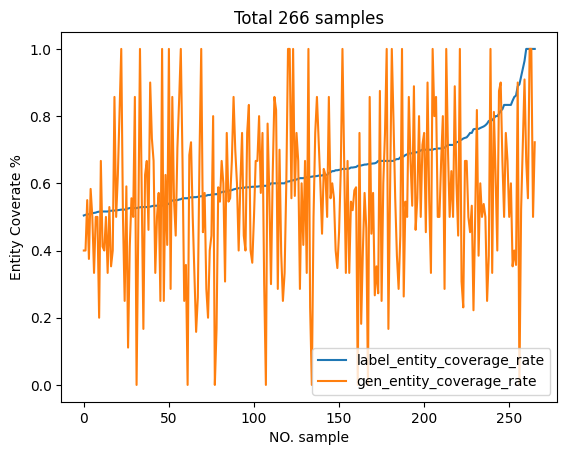

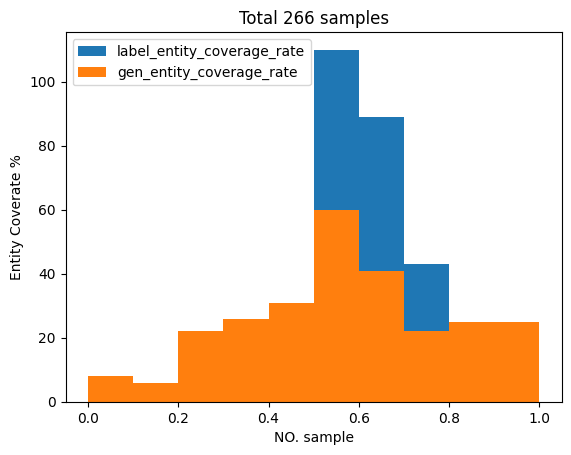

In [14]:
# ontology analysis
df_w_ontology = result_set
df_w_ontology = df_w_ontology.sort_values(by='label_entity_coverage_rate').reset_index(drop=True)
ax_plot=df_w_ontology.plot(y = ['label_entity_coverage_rate', 'gen_entity_coverage_rate'],
                                  kind='line',
                                  xlabel='NO. sample',
                                  ylabel='Entity Coverate %',
                                  title=f'Total {df_w_ontology.shape[0]} samples')

ax_plot=df_w_ontology.plot(y = ['label_entity_coverage_rate', 'gen_entity_coverage_rate'],
                                  kind='hist',
                                  xlabel='NO. sample',
                                  ylabel='Entity Coverate %',
                                  title=f'Total {df_w_ontology.shape[0]} samples')

# cursor_coverage_rate = 0.8
# cursor_index = sorted_coverate_rate[sorted_coverate_rate==cursor_coverage_rate].index[0]

# def mark_out_point(plot_ax, a_pos, b_pos):
#     plot_ax.axhline(y=b_pos, color='r', linestyle='--')
#     plot_ax.axvline(x=a_pos, color='g', linestyle='--')

#     plot_ax.plot(a_pos, b_pos, 'ro')
#     return plot_ax

# mark_out_point(ax_plot, cursor_index, cursor_coverage_rate)


In [20]:
analysis_set = result_set.sort_values(by='label_entity_coverage_rate').reset_index(drop=True)
# analysis_set['normed_SGR'] = analysis_set['SGR']/10
analysis_set.plot(y=['label_entity_coverage_rate', 'SGR', 'HR'], kind='line', ylabel='rate', xlabel='sample index')

KeyError: "['SGR', 'HR'] not in index"

In [1]:
import pandas as pd

In [4]:
result_set = pd.read_json('../../outputs/OLMO-1B-Notes_20240320015158/evals/analysis/all_merged_for_case_study.jsonl', lines=True)